In [1]:
# hide
# all_slow

In [2]:
# hide
# no_test
! [ -e /content ] && pip install -Uqq geowrangler

In [3]:
# hide
# no_test
!mkdir -p ../data
![ -e /content ] && ln -s ../data .

In [4]:
# hide
# no_test
!mkdir -p ../data
# download sample geojson files from repo

In [5]:
# hide
# no_test
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Raster to Dataframe Tutorial

> A basic introduction to Vector to Raster mask and Raster to Dataframe.

## Basic Usage

Generate a raster mask from a reference TIF image based on the labels assigned to certain regions of the area. The generated raster mask can also be used to convert the raster to a dataframe with respect to their assigned labels. 

Terms:
* **raster mask** - processed image wherein some parts of it are set to no value or in other words *hidden*
* **labels** - parts of an area within the satellite image are categorized as such. Examples are mining, agriculture, etc.

In [6]:
# hide
# no_test
!mkdir -p ../data
# download sample geojson files from repo
![ ! -e ../data/region34ncr_admin.geojson ] && curl -s -o ../data/region34ncr_admin.geojson https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/vector_to_raster_mask_sample/cabanglasan.tif
![ ! -e ../data/region3_admin_grids.geojson ] && curl -s -o ../data/region3_admin_grids.geojson https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/vector_to_raster_mask_sample/labels_20220816.gpkg

In [7]:
# hide
import warnings

from shapely.errors import ShapelyDeprecationWarning

warnings.filterwarnings(action="ignore", category=UserWarning, module="geopandas")
warnings.filterwarnings(
    action="ignore", category=ShapelyDeprecationWarning, module="pandas"
)

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

import geowrangler.raster_to_dataframe as rdf

In [9]:
from rasterio import features
from rasterio.plot import show
from rasterio.windows import Window, transform

### Load reference raster image and shape file

The shape file that should be loaded should contain a column that consists of labels. 

In [10]:
tiff_file = "../data/vector_to_raster_mask_sample/cabanglasan.tif"
shape_file = "../data/vector_to_raster_mask_sample/labels_20220816.gpkg"
target_file = shape_file.replace("gpkg", "tiff")

We create a dictionary of our target labels that we want to create a raster mask for.

In [11]:
labels = {
    "mining": 1,
    "neg": 2,
    "agriculture": 3,
    "product_extraction": 4,
    "kaingin": 5,
    "biophysical": 6,
}

### Generate raster mask

To create the mask we input the reference raster image, shape file with labels, and the dictionary with our target labels into the function.

/home/abbymoreno/geowrangler/geowrangler/raster_to_dataframe.py:29: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gs = gdf.explode()


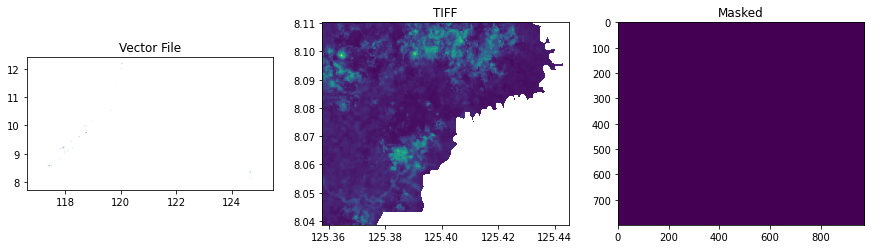

In [12]:
# Generate masks for a file
masks, grids, values = rdf.generate_mask(
    tiff_file=tiff_file,
    shape_file=shape_file,
    output_file=target_file,
    labels_column="label",
    labels_dict=labels,
    plot=True,
)

### Load rasters and the outputed raster mask

In [13]:
# no_test
tiff_files = [
    "../data/vector_to_raster_mask_sample/cabanglasan.tif",
]
mask_file = "../data/vector_to_raster_mask_sample/labels_20220816.tiff"

### Convert raster to dataframe

To convert raster/s to a dataframe, we just need to input the images into the function and add the mask file. The mask file will be used to create the last column `label` in the dataframe. The result is a tabular dataset that contains the Band values per raster image and their labels.

In [14]:
data = rdf.read_bands(tiff_files, mask_file)

In [15]:
data

,B1_0,B2_0,B3_0,B4_0,B5_0,B6_0,B7_0,B8_0,B9_0,B10_0,B11_0,B12_0,label
0,0.1198,0.09635,0.09330,0.0698,0.10665,0.20250,0.2490,0.23525,0.28125,0.0377,0.19925,0.1002,0
1,0.1198,0.09580,0.09245,0.0708,0.10665,0.20250,0.2490,0.23925,0.28125,0.0377,0.19925,0.1002,0
2,0.1148,0.09420,0.09460,0.0707,0.10380,0.20395,0.2478,0.23150,0.27165,0.0385,0.18240,0.0902,0
3,0.1148,0.09190,0.08850,0.0631,0.10380,0.20395,0.2478,0.23300,0.27165,0.0385,0.18240,0.0902,0
4,0.1148,0.09350,0.09080,0.0643,0.10565,0.20830,0.2466,0.24205,0.26990,0.0385,0.18050,0.0894,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
775824,0.0000,0.00000,0.00000,0.0000,0.00000,0.00000,0.0000,0.00000,0.00000,0.0000,0.00000,0.0000,0
775825,0.0000,0.00000,0.00000,0.0000,0.00000,0.00000,0.0000,0.00000,0.00000,0.0000,0.00000,0.0000,0
775826,0.0000,0.00000,0.00000,0.0000,0.00000,0.00000,0.0000,0.00000,0.00000,0.0000,0.00000,0.0000,0
775827,0.0000,0.00000,0.00000,0.0000,0.00000,0.00000,0.0000,0.00000,0.00000,0.0000,0.00000,0.0000,0


Checking the `label` column we can see that the TIF image that we converted does not contain the desired labels.

In [16]:
data["label"].unique()

array([0], dtype=uint16)